In [ ]:
!pip install gym
!pip install stable_baselines3
!pip install panda_gym==2.0.0
!apt install -y python-opengl ffmpeg > /dev/null 2>&1
!sudo apt-get update -y
!sudo apt-get install python3.9
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:9 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InReleas

In [ ]:
import gym
import matplotlib.pyplot as plt
import pandas as pd
import os
import panda_gym
import numpy as np
import os
import torch
from stable_baselines3 import TD3, HerReplayBuffer, DDPG, SAC
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import configure

class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}.zip")
                  self.model.save(self.save_path)

        return True

In [ ]:
log_dir_ddpg = "/tmp/gym/PandaReachDDPG"
log_dir_sac = "/tmp/gym/PandaReachSAC"
save_dir_ddpg = "/tmp/gym/PandaReachDDPGSave"
save_dir_sac = "/tmp/gym/PandaReachSACSave"
os.makedirs(log_dir_ddpg, exist_ok=True)
os.makedirs(log_dir_sac, exist_ok=True)
ddpg_logger = configure(log_dir_ddpg, ["stdout", "csv", "tensorboard"])
env = gym.make("PandaReach-v2")
env = Monitor(env, log_dir_ddpg)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir_ddpg)
replay_buffer_kwargs=dict(
      n_sampled_goal=4,
      goal_selection_strategy="future",
      max_episode_length=100,
      online_sampling=True,)
n_actions = env.action_space.shape[-1]
noise = NormalActionNoise(mean=np.zeros(n_actions), sigma= 0.3 * np.ones(n_actions))
model_ddpg = DDPG("MultiInputPolicy", env, action_noise=noise, verbose=1, batch_size=1024, policy_kwargs=dict(net_arch=[256,256]), replay_buffer_class = HerReplayBuffer,gamma = 0.95, buffer_size=1000000)
model_ddpg.set_logger(ddpg_logger)
model_ddpg.learn(total_timesteps=20000)
model_ddpg.save("DDPG_Panda_Reach", save_dir_ddpg)


Logging to /tmp/gym/PandaReachDDPG
Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -49.5    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 180      |
|    time_elapsed    | 1        |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | 0.555    |
|    critic_loss     | 0.25     |
|    learning_rate   | 0.001    |
|    n_updates       | 50       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -49.8    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 68       |
|    time_elapsed    | 5        |
|    total_timesteps | 400      |
| train/             |      

In [ ]:
env = gym.make("PandaReach-v2")
env = Monitor(env, log_dir_sac)
sac_logger = configure(log_dir_sac, ["stdout", "csv", "tensorboard"])
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir_sac)
replay_buffer_kwargs=dict(
      n_sampled_goal=4,
      goal_selection_strategy="future",
      max_episode_length=100,
      online_sampling=True,)
n_actions = env.action_space.shape[-1]
noise = NormalActionNoise(mean=np.zeros(n_actions), sigma= 0.3 * np.ones(n_actions))
model_sac = SAC("MultiInputPolicy", env, action_noise=noise, verbose=1, batch_size=1024, policy_kwargs=dict(net_arch=[256,256]), replay_buffer_class = HerReplayBuffer,gamma = 0.95, buffer_size=1000000)
model_sac.set_logger(sac_logger)
model_sac.learn(total_timesteps=20000)
model_sac.save("SAC_Panda_Reach")

Logging to /tmp/gym/PandaReachSAC
Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 92       |
|    time_elapsed    | 2        |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | -3.37    |
|    critic_loss     | 0.243    |
|    ent_coef        | 0.971    |
|    ent_coef_loss   | -0.148   |
|    learning_rate   | 0.0003   |
|    n_updates       | 99       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 68       |
|    time_elapsed    | 5     

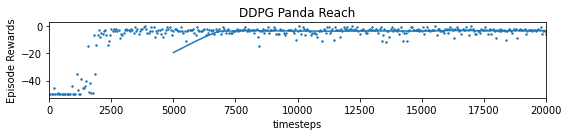

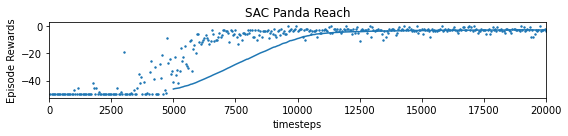

In [ ]:
from stable_baselines3.common import results_plotter

# Helper from the library

results_plotter.plot_results([log_dir_ddpg], 1e5, results_plotter.X_TIMESTEPS, "DDPG Panda Reach")
results_plotter.plot_results([log_dir_sac], 1e5, results_plotter.X_TIMESTEPS, "SAC Panda Reach")

In [ ]:

def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder1, log_folder2, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    ddpg_path = os.path.join(log_folder1,"progress.csv")
    ddpg_data = pd.read_csv(ddpg_path)
    x1 = ddpg_data.loc[:,'time/total_timesteps']
    y1 = ddpg_data.loc[:,"rollout/success_rate"]
    sac_path = os.path.join(log_folder2,"progress.csv")
    sac_data = pd.read_csv(sac_path)
    x2 = sac_data.loc[:,'time/total_timesteps']
    y2 = sac_data.loc[:,"rollout/success_rate"]
    y1 = moving_average(y1, window=50)
    y2 = moving_average(y2, window=50)
    # Truncate x
    x1 = x1[len(x1) - len(y1):]
    x2 = x2[len(x2) - len(y2):]
    fig = plt.figure(title)
    plt.plot(x1, y1, label="DDPG")
    plt.plot(x2, y2, label="SAC")
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Success Rate')
    plt.title("Learning Curve for Reach Task")
    plt.legend()
    plt.show()


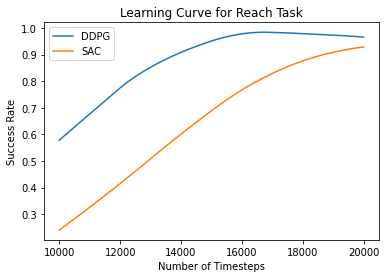

In [ ]:
plot_results(log_dir_ddpg, log_dir_sac)

In [ ]:
env = gym.make("PandaReach-v2", render=True)
model_ddpg = DDPG.load("DDPG_Panda_Reach", env=env)
frames = []
observation = env.reset()
for _ in range(10):
    done = False
    observation = env.reset()
    while not done:
        action, _states = model_ddpg.predict(observation, deterministic = True)
        observation, reward, done, info = env.step(action)
        frame = env.render(mode='rgb_array')
        frames.append(frame)

env.close()

NameError: ignored

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [3,519 kB]
Get:14 http://ppa.launchpad.net